# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from pseudoset import PseudoSet
import pickle
import os
import sys
import time

ROOT = os.path.join("./")
sys.path.append(ROOT + "lib")
sys.path.append(ROOT + "models")

from helpers import *
from sourceset import SourceSet
from fourier import *
from cnn import CNN
from transformer import *
from final import *
from general_trainer import compete, gen_train


device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)
device

'cuda'

In [2]:
with open(ROOT + "processed_datasets/pseudotrain.pt", "rb") as f:
  data_train = torch.load(f, map_location=device)
with open(ROOT + "processed_datasets/pseudovalid.pt", "rb") as f:
  data_valid = torch.load(f, map_location=device)

train = DataLoader(data_train, batch_size=None, shuffle=True, generator=torch.Generator(device=device))
valid = DataLoader(data_valid, batch_size=None, shuffle=False, generator=torch.Generator(device=device))

# with open(ROOT + "processed_datasets/data_train.pt", "rb") as f:
#   data_train = torch.load(f, map_location=device)
# with open(ROOT + "processed_datasets/data_valid.pt", "rb") as f:
#   data_valid = torch.load(f, map_location=device)

# train = DataLoader(data_train, batch_size=500, shuffle=True, generator=torch.Generator(device=device), collate_fn=padded_collate)
# valid = DataLoader(data_valid, batch_size=1, shuffle=False, generator=torch.Generator(device=device), collate_fn=tracking_validation_collate)


data_train, data_valid

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [3]:
for ex, l in train:
  print(ex.shape, l.shape)

torch.Size([1, 95, 3]) torch.Size([1, 4])
torch.Size([13, 33263, 3]) torch.Size([13, 4])
torch.Size([33, 442, 3]) torch.Size([33, 4])
torch.Size([1, 40, 3]) torch.Size([1, 4])
torch.Size([31, 662, 3]) torch.Size([31, 4])
torch.Size([1, 20, 3]) torch.Size([1, 4])
torch.Size([1, 200, 3]) torch.Size([1, 4])
torch.Size([15, 2102, 3]) torch.Size([15, 4])
torch.Size([13, 1102, 3]) torch.Size([13, 4])
torch.Size([1, 121, 3]) torch.Size([1, 4])
torch.Size([17, 4002, 3]) torch.Size([17, 4])
torch.Size([1, 50, 3]) torch.Size([1, 4])
torch.Size([84, 222, 3]) torch.Size([84, 4])
torch.Size([64, 310, 3]) torch.Size([64, 4])
torch.Size([1, 30, 3]) torch.Size([1, 4])


# Model

In [13]:
kwargs = dict(out=4)
model = CNN(**kwargs).to(device)

# kwargs = dict(samples=512, out=4, learnsamples=True)
# model = CNFourierModel(**kwargs).to(device)
model_pars = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_pars])

for p in model.named_parameters():
    print(p[0], np.prod(p[1].size()))
print(params)

conv1.weight 144
conv1.bias 12
conv2.weight 3072
conv2.bias 32
conv3.weight 16384
conv3.bias 64
conv4.weight 16384
conv4.bias 32
conv5.weight 4096
conv5.bias 16
lstm.weight_ih_l0 1536
lstm.weight_hh_l0 2304
lstm.bias_ih_l0 96
lstm.bias_hh_l0 96
lstm.weight_ih_l1 2304
lstm.weight_hh_l1 2304
lstm.bias_ih_l1 96
lstm.bias_hh_l1 96
fc1.weight 192
fc1.bias 8
fc2.weight 32
fc2.bias 4
49304


# Training Loop (Single)

In [35]:
kwargs = dict(samples=1024, out=4, learnsamples=True)
model = CNFourierModel(**kwargs).to(device)
# kwargs = dict(out=4)
# model = CNN(**kwargs).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00004, weight_decay=10**-5.1, amsgrad=True)
loss = torch.nn.CrossEntropyLoss().to(device)
gen_train(model, kwargs, optim, loss, train, valid, 1200, False, tracking=True)

Most Failed:  0
Epoch  507 :  0.30521467834090193
nulls: 0.9999999666666678 novas:  0.8666666377777787 pulsators:  0.8333330555556482 transits:  0.7666664111111963


KeyboardInterrupt: 

In [ ]:
# Valid dataloader as list is comprised of ( (N x T x F), N x Label )
datas = [pair[0] for pair in valid]
labels = [pair[1] for pair in valid]
validaccessor = (torch.concat(datas, dim = 0), torch.concat(labels, dim = 0)) # Now just (# of exs) x T x F

selector = 8
pair = (validaccessor[0][selector], validaccessor[1][selector])

plot_from_tensor(pair[0])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

or

In [ ]:
higher = FourierModel(512,3,learnsamples=True)
lower = FourierModel2(512,3,learnsamples=True)

optim1 = torch.optim.AdamW(higher.parameters(), lr=0.00004, weight_decay=10**-5.5, amsgrad=True)
optim2 = torch.optim.AdamW(lower.parameters(), lr=0.00004, weight_decay=10**-5.5, amsgrad=True)

compete([("amsgrad no", higher, optim1), ("amsgrad yes", lower, optim2)], 500, train, valid)

# Analyze

STAGE:2024-02-09 10:59:41 18215:18215 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-09 10:59:41 18215:18215 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-09 10:59:41 18215:18215 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


conv1.weight
3.8197810649871826
conv1.bias
4.539357662200928
conv2.weight
27.770156860351562
conv2.bias
4.690060615539551
conv3.weight
37.221988677978516
conv3.bias
5.998870849609375
conv4.weight
58.052589416503906
conv4.bias
4.135871887207031
conv5.weight
58.242252349853516
conv5.bias
2.7993581295013428
conv6.weight
44.74654769897461
conv6.bias
1.9857537746429443
layone.weight
43.18659973144531
layone.bias
1.2742761373519897
laytwo.weight
9.148889541625977
laytwo.bias
3.2454264163970947
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  -----------

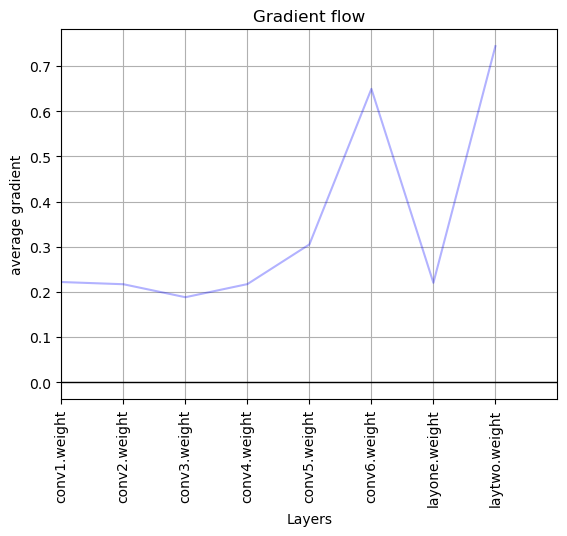

In [ ]:
torch.cuda.empty_cache()
# model = AnomalyDetector(emb_dim=16, out=4).to(device)
kwargs = dict(samples=1024,out=4)
model = CNFourierModel(**kwargs).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
  for data, label in train:
    data = data.to(device)
    model.train()
    with record_function("fiojsda"):
      out = model(data)
      loss = loss_fn(out, label)
      loss.backward()
      
model.train
for n, p in model.named_parameters():
  print(n)
  print(p.grad.norm().item())

plot_grad_flow(model.cpu().named_parameters())

# print("TOTAL TIME: ", (t2-t1) * 10**3, "ms")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=8))